In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
cmap = ['#491212FF', '#F27127FF', '#F24C27FF', '#BF281BFF', '#CE471CFF']

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Propsih/test/main/data_test.csv', sep=';')

Посмотрим, сколько клиентов в датасете

In [4]:
num_cls = df.CLIENT_ID.nunique()
print(num_cls)

169092


In [ ]:
df.head()

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
0,3596869440,30.09.2021,18.0,8.0,9.0
1,181778433,30.09.2021,7.0,3.0,3.0
2,4271531990,30.09.2021,2.0,0.0,0.0
3,3949165697,30.09.2021,15.0,4.0,5.0
4,1926920317,30.09.2021,3.0,0.0,0.0


То есть в данном датасете, если не было совершено ни одного действия: ни транзакции без приложения, ни взаимодействия с приложением, строка заполняется значениями NaN. Если же некоторое из действий было совершено, а другие нет, то пропуск заполняется нулем, а не с помощью NaN. В случае, если клиент перестал быть клиентом, то строка не присутствует.

In [ ]:
'''
  Сначала выбираем только те строки, в которых хотя бы раз встречается NaN,
  затем смотрим на колонки DIGITAL_30_CNT, TRAN_ACTIVE_30_CNT, OPER_ACTIVE_30_CNT
  Заменяем NaN на 0, чтобы просуммироват значения по строкам:
  если бы хотя бы в одной строке встретилось не значение NaN, то получилось число, отличное от 0
'''
print(df[df.isna().max(axis=1)].iloc[:, 2:].fillna(0).sum(axis=1).unique())

[0.]


Сколько всего записей

In [ ]:
num_rows = df.shape[0]
print(num_rows)

805821


Сколько раз в среднем встречается каждый клиент

In [ ]:
print(f'{num_rows / num_cls:.2f}')

4.77


In [ ]:
ds = df.groupby(['CLIENT_ID', 'VALUE_DAY']).DIGITAL_30_CNT.count().reset_index()
ds[ds.DIGITAL_30_CNT > 1]

,CLIENT_ID,VALUE_DAY,DIGITAL_30_CNT
340851,1813118018,28.02.2022,2
340854,1813118018,31.01.2022,2


Есть всего две строчки в датафрейме у одного клиента, можем обработать вручную. Два варианта: обработать суммированием, подразумевая, что строчки подсчитывали разные действия клиента, например, на разных устройствах, или максимумом, подразумевая, что одна из строчек – недостаточно подсчитанная вторая. В любом случае, выбор не будет значимо влиять на результат, обработаем суммой.

In [107]:
df[['DIGITAL_30_CNT', 'TRAN_ACTIVE_30_CNT', 'OPER_ACTIVE_30_CNT']].fillna(0).corr()

,DIGITAL_30_CNT,TRAN_ACTIVE_30_CNT,OPER_ACTIVE_30_CNT
DIGITAL_30_CNT,1.000000,0.598861,0.641820
TRAN_ACTIVE_30_CNT,0.598861,1.000000,0.903343
OPER_ACTIVE_30_CNT,0.641820,0.903343,1.000000


In [37]:
sns.set_theme(palette=cmap, style='darkgrid', font_scale=0.9)

In [80]:
df1 = df.groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df2 = df[df.DIGITAL_30_CNT.isna()].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df1 = df1.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df2 = df2.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df1 = pd.merge(df1, df2, on='VALUE_DAY', suffixes=['_total', '_active'])
df1['ratio'] = (1 - df1['num_clients_active'] / df1['num_clients_total']) * 100
df1.VALUE_DAY = pd.to_datetime(df1.VALUE_DAY).dt.normalize()

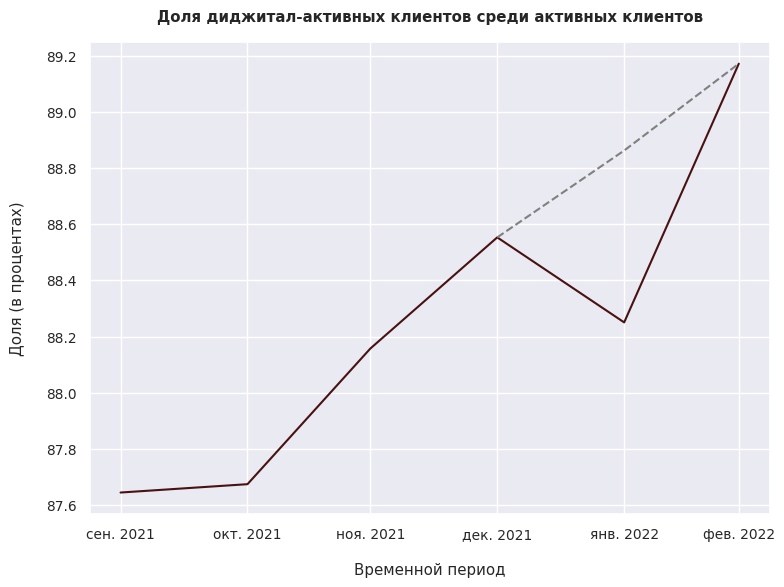

In [81]:
plt.figure(figsize=(8, 6))
sns.lineplot(df1, x='VALUE_DAY', y='ratio', palette=cmap)
arr = df1.ratio.to_numpy()
arr[4] = (arr[3] + arr[5]) / 2
sns.lineplot(x=df1.VALUE_DAY.to_numpy()[3:], y=arr[3:], linestyle="--", color='grey')
lst = df1.VALUE_DAY.tolist()
lst.sort()
plt.xticks(ticks=lst,
           labels=['сен. 2021', 'окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022',
                   ])
plt.xlabel('Временной период', labelpad=15)
plt.ylabel('Доля (в процентах)', labelpad=15)
plt.title(
          "Доля диджитал-активных клиентов среди активных клиентов",
          fontweight='bold',
          pad=15
          )
plt.tight_layout()
plt.savefig("Диджитал-активные.jpg", dpi=700);

In [128]:
df1 = df[(df.DIGITAL_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df2 = df[(df.DIGITAL_30_CNT > 0) & (df.TRAN_ACTIVE_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df1 = df1.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df2 = df2.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df1 = pd.merge(df1, df2, on='VALUE_DAY', suffixes=['_total', '_active'])
df1['ratio'] = df1['num_clients_active'] / df1['num_clients_total'] * 100
df1.VALUE_DAY = pd.to_datetime(df1.VALUE_DAY).dt.normalize()

Видим, что доля клиентов, не совершивших ни одной транзакции, имеет тренд к снижению. Наблюдаем рост в районе января: можно предположить, что клиенты, которые начали пользоваться услугами в результате промо-акций, так и не стали активными клиентами (продолжают пользоваться услугами других банков, получили карту "случайно" и др.)

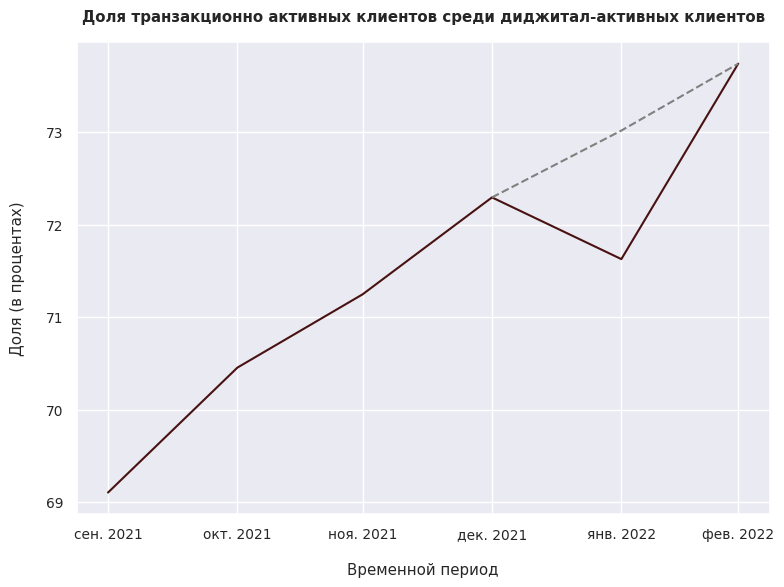

In [129]:
plt.figure(figsize=(8, 6))
sns.lineplot(df1, x='VALUE_DAY', y='ratio', palette=cmap)
arr = df1.ratio.to_numpy()
arr[4] = (arr[3] + arr[5]) / 2
sns.lineplot(x=df1.VALUE_DAY.to_numpy()[3:], y=arr[3:], linestyle="--", color='grey')
lst = df1.VALUE_DAY.tolist()
lst.sort()
plt.xticks(ticks=lst,
           labels=['сен. 2021', 'окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022',
                   ])
plt.xlabel('Временной период', labelpad=15)
plt.ylabel('Доля (в процентах)', labelpad=15)
plt.title(
          "Доля транзакционно активных клиентов среди диджитал-активных клиентов",
          fontweight='bold',
          pad=15
          )
plt.tight_layout()
plt.savefig("Транзакционно активные.jpg", dpi=700);

In [ ]:
df1 = df[(df.DIGITAL_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df2 = df[(df.DIGITAL_30_CNT > 0) & (df.TRAN_ACTIVE_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df1 = df1.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df2 = df2.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df1 = pd.merge(df1, df2, on='VALUE_DAY', suffixes=['_total', '_active'])
df1['ratio'] = df1['num_clients_active'] / df1['num_clients_total'] * 100
df1.VALUE_DAY = pd.to_datetime(df1.VALUE_DAY).dt.normalize()

''

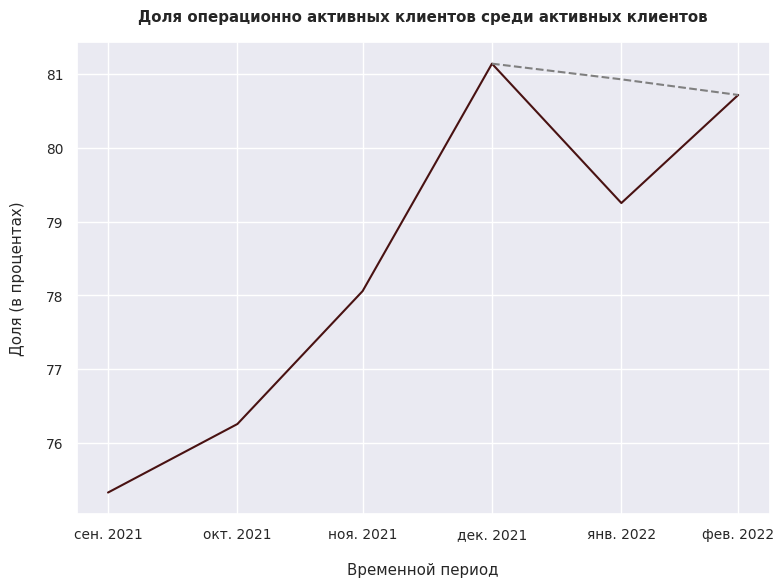

In [77]:
plt.figure(figsize=(8, 6))
sns.lineplot(df1, x='VALUE_DAY', y='ratio', palette=cmap)
arr = df1.ratio.to_numpy()
arr[4] = (arr[3] + arr[5]) / 2
sns.lineplot(x=df1.VALUE_DAY.to_numpy()[3:], y=arr[3:], linestyle="--", color='grey')
lst = df1.VALUE_DAY.tolist()
lst.sort()
plt.xticks(ticks=lst,
           labels=['сен. 2021', 'окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022',
                   ])
plt.xlabel('Временной период', labelpad=15)
plt.ylabel('Доля (в процентах)', labelpad=15)
plt.title("Доля операционно активных клиентов среди активных клиентов",
          fontweight='bold',
          pad=15)
plt.tight_layout()
plt.savefig("Операционно активные.jpg", dpi=700)
;

In [94]:
df1 = df[(df.OPER_ACTIVE_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df2 = df[(df.OPER_ACTIVE_30_CNT > 0) & (df.TRAN_ACTIVE_30_CNT > 0)].groupby('VALUE_DAY').CLIENT_ID.nunique().reset_index()
df1 = df1.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df2 = df2.rename({'CLIENT_ID': 'num_clients'}, axis=1)
df1 = pd.merge(df1, df2, on='VALUE_DAY', suffixes=['_total', '_active'])
df1['ratio'] = df1['num_clients_active'] / df1['num_clients_total'] * 100
df1.VALUE_DAY = pd.to_datetime(df1.VALUE_DAY).dt.normalize()

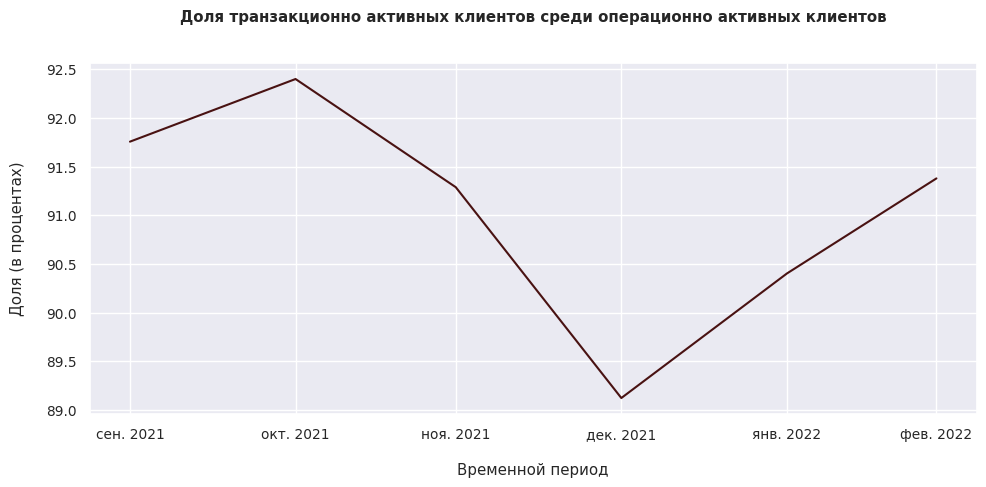

In [95]:
plt.figure(figsize=(10, 5))
sns.lineplot(df1, x='VALUE_DAY', y='ratio', palette=cmap)
lst = df1.VALUE_DAY.tolist()
lst.sort()
plt.xticks(ticks=lst,
           labels=['сен. 2021', 'окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022',
                   ])
plt.xlabel('Временной период', labelpad=15)
plt.ylabel('Доля (в процентах)', labelpad=15)
plt.title("Доля транзакционно активных клиентов среди операционно активных клиентов",
          fontweight='bold',
          pad=30,
          loc='center')

plt.tight_layout()
plt.savefig("Доля транзакционных среди операционных.jpg", dpi=700);

In [82]:
df['is_active'] = 1
df['is_digital_active'] = (df.DIGITAL_30_CNT > 0).astype(int)
df['is_tran_active'] = (df.TRAN_ACTIVE_30_CNT > 0).astype(int)
df['is_oper_active'] = (df.OPER_ACTIVE_30_CNT > 0).astype(int)

In [83]:
df.VALUE_DAY = pd.to_datetime(df.VALUE_DAY).dt.normalize()

In [89]:
column_list = ['is_active', 'is_digital_active', 'is_tran_active', 'is_oper_active']
dataframe = None

for el in column_list:
  ddf = pd.pivot_table(
                      df,
                      index='CLIENT_ID',
                      columns='VALUE_DAY',
                      values=[el],
                      fill_value=0
                      ).astype(int).reset_index()

  x = []
  for i in range(1, 6):
    x.append(
            [ddf.columns[i][1], (ddf.iloc[:, i] * ddf.iloc[:, i+1]).sum(axis=0) / ddf.iloc[:, i].sum(axis=0) * 100]
            )
  word = 'Retention_rate' + '_' + el
  if dataframe is None:
      dataframe = pd.DataFrame(x, columns=['Date', word])
  else:
      dataframe = pd.merge(dataframe, pd.DataFrame(x, columns=['Date', word]), on='Date')

In [85]:
dataframe

,Date,Retention_rate_is_active,Retention_rate_is_digital_active,Retention_rate_is_tran_active,Retention_rate_is_oper_active
0,2021-09-30,96.410332,93.503123,83.871791,84.643033
1,2021-10-31,96.169010,93.652933,84.249057,85.727743
2,2021-11-30,96.222812,93.652396,85.009685,86.899668
3,2021-12-31,88.947976,86.078882,76.338471,76.783029
4,2022-01-31,96.623529,94.709228,87.006250,87.468146


In [90]:
ts1 = df.groupby('CLIENT_ID').VALUE_DAY.min().reset_index().groupby('VALUE_DAY').count().reset_index().CLIENT_ID.tolist()
ts2 = df.groupby('CLIENT_ID').VALUE_DAY.max().reset_index().groupby('VALUE_DAY').count().reset_index().CLIENT_ID.tolist()

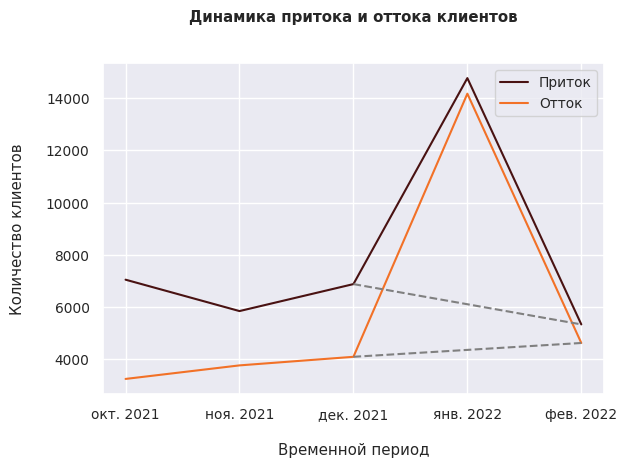

In [121]:
sns.lineplot(ts1[1:], label='Приток')
sns.lineplot(ts2[:-1], label='Отток')
ts1_ = ts1[1:].copy()
ts1_[3] = (ts1_[2] + ts1_[4]) / 2
ts1_[0], ts1_[1] = np.nan, np.nan
ts2_ = ts2[:-1].copy()
ts2_[3] = (ts2_[2] + ts2_[4]) / 2
ts2_[0], ts2_[1] = np.nan, np.nan
sns.lineplot(ts1_, linestyle="--", color='grey')
sns.lineplot(ts2_, linestyle="--", color='grey')
plt.xticks(ticks=range(5), labels=['окт. 2021', 'ноя. 2021', 'дек. 2021', 'янв. 2022', 'фев. 2022'])
plt.xlabel('Временной период', labelpad=15)
plt.ylabel('Количество клиентов', labelpad=15)
plt.legend()
plt.title("Динамика притока и оттока клиентов",
          fontweight='bold',
          pad=30,
          loc='center')
plt.tight_layout()
plt.savefig("Динамика притока и оттока клиентов.jpg", dpi=700)
plt.show()


Протестить гипотезу можно с помощью соответствия ФИО старых клиентов и новых клиентов или паспортных данных, если возможно использовать данную информацию.

Вообще, приток клиентов в какой-то временной период многосоставен: есть часть клиентов, которые перевыпустили карту в тот месяц, в который прекратилось время действия предыдущий, большинство, как можно предположить по графику, перевыпускает на следующий месяц и получает новый CLIENT_ID, также есть часть клиентов, которые ранее не пользовались нашими услугами.

Можно попытаться протестировать, что выборки пришли из одного распределения. Однако некоторые временные влияния также могут влиять на распределение клиентов, так что можно делать поправку на момент времени. Попытаемся оценить ATE.

In [101]:
start = df.groupby('CLIENT_ID').VALUE_DAY.min().reset_index()
start = set(start[start.VALUE_DAY == df.VALUE_DAY.min()].CLIENT_ID.tolist())
finish = df.groupby('CLIENT_ID').VALUE_DAY.max().reset_index()
finish = set(finish[finish.VALUE_DAY == df.VALUE_DAY.max()].CLIENT_ID.tolist())
dff = df[df.CLIENT_ID.isin(start.intersection(finish))]

In [102]:
def get_retention_rate(df):
  column_list = ['is_active', 'is_digital_active', 'is_tran_active', 'is_oper_active']
  dataframe = None

  for el in column_list:
    ddf = pd.pivot_table(
                        df,
                        index='CLIENT_ID',
                        columns='VALUE_DAY',
                        values=[el],
                        fill_value=0
                        ).astype(int).reset_index()

    x = []
    for i in range(1, 6):
      x.append(
              [ddf.columns[i][1], (ddf.iloc[:, i] * ddf.iloc[:, i+1]).sum(axis=0) / ddf.iloc[:, i].sum(axis=0) * 100]
              )
    word = 'Retention_rate' + '_' + el
    if dataframe is None:
        dataframe = pd.DataFrame(x, columns=['Date', word])
    else:
        dataframe = pd.merge(dataframe, pd.DataFrame(x, columns=['Date', word]), on='Date')
  return dataframe

In [103]:
result = get_retention_rate(dff)
result['regular_customers'] = 1
result2 = get_retention_rate(df)
result2['regular_customers'] = 0
result = pd.concat((result, result2), axis=0)

In [104]:
lst = result.Date[:5]

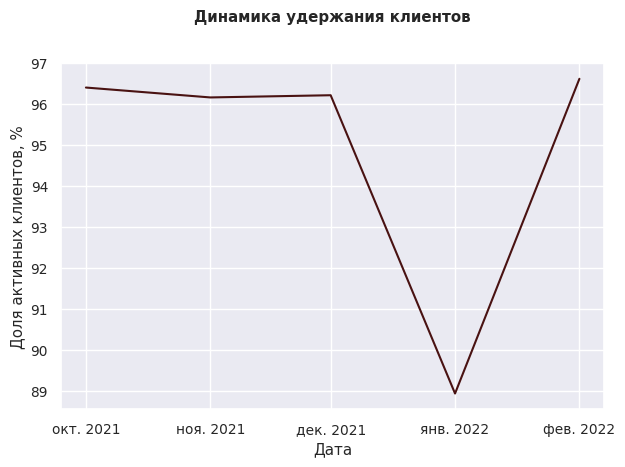

In [127]:
sns.lineplot(result[result.regular_customers == 0],
             x='Date', y='Retention_rate_is_active')
plt.xlabel('Дата')
plt.ylabel('Доля активных клиентов, %')
plt.xticks(ticks=lst,
           labels=['окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022'
                   ])
plt.title("Динамика удержания клиентов",
          fontweight='bold',
          pad=30,
          loc='center')
plt.tight_layout()
plt.savefig("Динамика удержания клиентов.jpg", dpi=700)
plt.show()

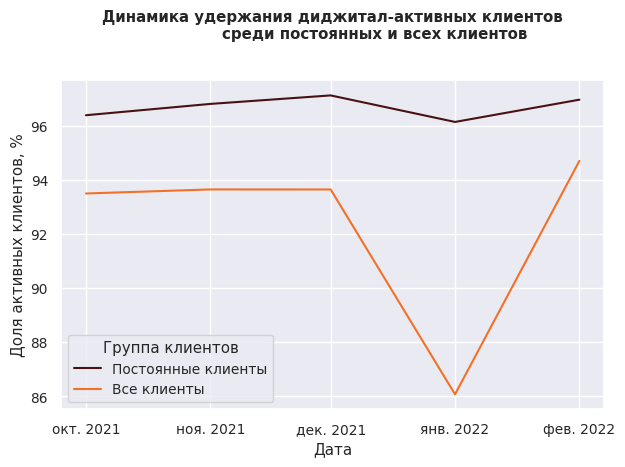

In [123]:
sns.lineplot(result[result.regular_customers == 1],
             x='Date', y='Retention_rate_is_digital_active',
             label='Постоянные клиенты')
sns.lineplot(result[result.regular_customers == 0],
             x='Date', y='Retention_rate_is_digital_active',
             label='Все клиенты')
plt.title("""Динамика удержания диджитал-активных клиентов
                среди постоянных и всех клиентов""",
          fontweight='bold',
          pad=30,
          loc='center')
plt.xlabel('Дата')
plt.ylabel('Доля активных клиентов, %')
plt.legend(title='Группа клиентов')
plt.xticks(ticks=lst,
           labels=['окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022'
                   ])
plt.tight_layout()
plt.savefig("Динамика удержания диджитал-активных клиентов среди постоянных и всех клиентов.jpg", dpi=700)
plt.show()

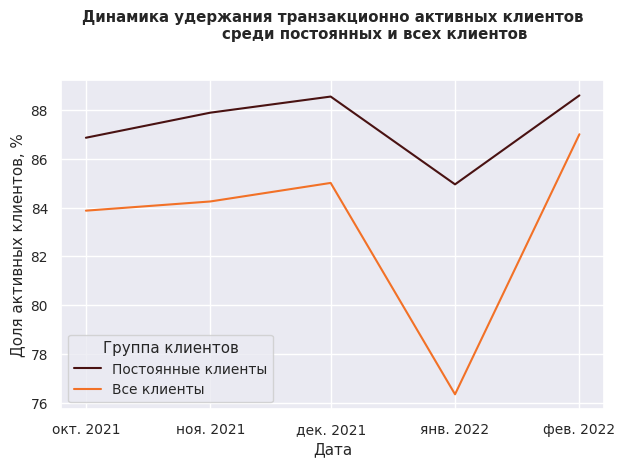

In [125]:
sns.lineplot(result[result.regular_customers == 1],
             x='Date', y='Retention_rate_is_tran_active',
             label='Постоянные клиенты')
sns.lineplot(result[result.regular_customers == 0],
             x='Date', y='Retention_rate_is_tran_active',
             label='Все клиенты')
plt.title("""Динамика удержания транзакционно активных клиентов
                среди постоянных и всех клиентов""",
          fontweight='bold',
          pad=30,
          loc='center')
plt.xlabel('Дата')
plt.ylabel('Доля активных клиентов, %')
plt.legend(title='Группа клиентов')
plt.xticks(ticks=lst,
           labels=['окт. 2021', 'ноя. 2021', 'дек. 2021',
                   'янв. 2022', 'фев. 2022'
                   ])
plt.tight_layout()
plt.savefig("Динамика удержания транзакционно активных клиентов среди постоянных и всех клиентов.jpg", dpi=700)
plt.show()